In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from scipy.optimize import minimize
from keras import regularizers
import scipy
import math
from sklearn.model_selection import train_test_split

In [2]:
dataTT = loadmat(f"Data04-08_TT_UltVag_Cut.mat")
dataTF = loadmat(f"Data04-08_TF_UltVag_Cut.mat")

dataBaseline = dataTF['Baseline']
dataCincoP = dataTF['CincoP']
dataDez = dataTF['DezP']
dataVinte = dataTF['VinteP']

dataBaseline = pd.DataFrame(dataBaseline)
x_test_Baseline = dataBaseline.sample(200, random_state = 42)
dataBaseline_train = dataBaseline.drop(x_test_Baseline.index)

dataCincoP = pd.DataFrame(dataCincoP)
x_test_Cinco = dataCincoP.sample(200, random_state = 42)
dataCincoP = dataCincoP.drop(x_test_Cinco.index)

dataDez = pd.DataFrame(dataDez)
x_test_Dez = dataDez.sample(200, random_state = 42)
dataDez = dataDez.drop(x_test_Dez.index)

dataVinte = pd.DataFrame(dataVinte)
x_test_Vinte = dataVinte.sample(200, random_state = 42)
dataVinte = dataVinte.drop(x_test_Vinte.index)

In [14]:
def run_autoencoder(dataBaseline, x_test_Baseline):

    num_terms = dataBaseline.columns.shape[0]
    input_layer = Input(shape=(num_terms,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(10e-5))(encoded)
    
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(32, activation='relu')(decoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dense(num_terms, activation='linear')(decoded)

    autoencoder = keras.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mae')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20) 

    autoencoder.fit(dataBaseline, dataBaseline,
                    epochs=100,
                    batch_size=32,
                    shuffle=True,
                    callbacks = [callback],
                    validation_data=(x_test_Baseline, x_test_Baseline),
                    verbose = 0)
    
    # plt.plot(autoencoder.history.history["loss"])
    # plt.xlabel("Iteration")
    # plt.yscale('log')
    # plt.ylabel("Loss")
    # plt.grid()

    return autoencoder

#autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)

In [10]:
# def run_autoencoder(dataBaseline, x_test_Baseline):

#     num_terms = dataBaseline.columns.shape[0]
#     input_layer = Input(shape=(num_terms,))
#     encoded = layers.Dense(64, activation='relu')(input_layer)
#     encoded = layers.Dense(32, activation='relu')(encoded)
#     encoded = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l1(2*10e-5))(encoded)

#     decoded = layers.Dense(16, activation='relu')(encoded)
#     decoded = layers.Dense(32, activation='relu')(encoded)
#     decoded = layers.Dense(64, activation='relu')(decoded)
#     decoded = layers.Dense(num_terms, activation='linear')(decoded)

#     autoencoder = keras.Model(input_layer, decoded)

#     autoencoder.compile(optimizer='adam', loss='mse', metrics = 'accuracy')

#     callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100) 

#     autoencoder.fit(dataBaseline, dataBaseline,
#                     epochs=200,
#                     batch_size=32,
#                     shuffle=True,
#                     callbacks = [callback],
#                     validation_data=(x_test_Baseline, x_test_Baseline),
#                     verbose = 0)
    
#     # plt.plot(autoencoder.history.history["loss"])
#     # plt.xlabel("Iteration")
#     # plt.yscale('log')
#     # plt.ylabel("Loss")
#     # plt.grid()

#     return autoencoder

# #autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)

7/7 [==============================] - 0s 2ms/step


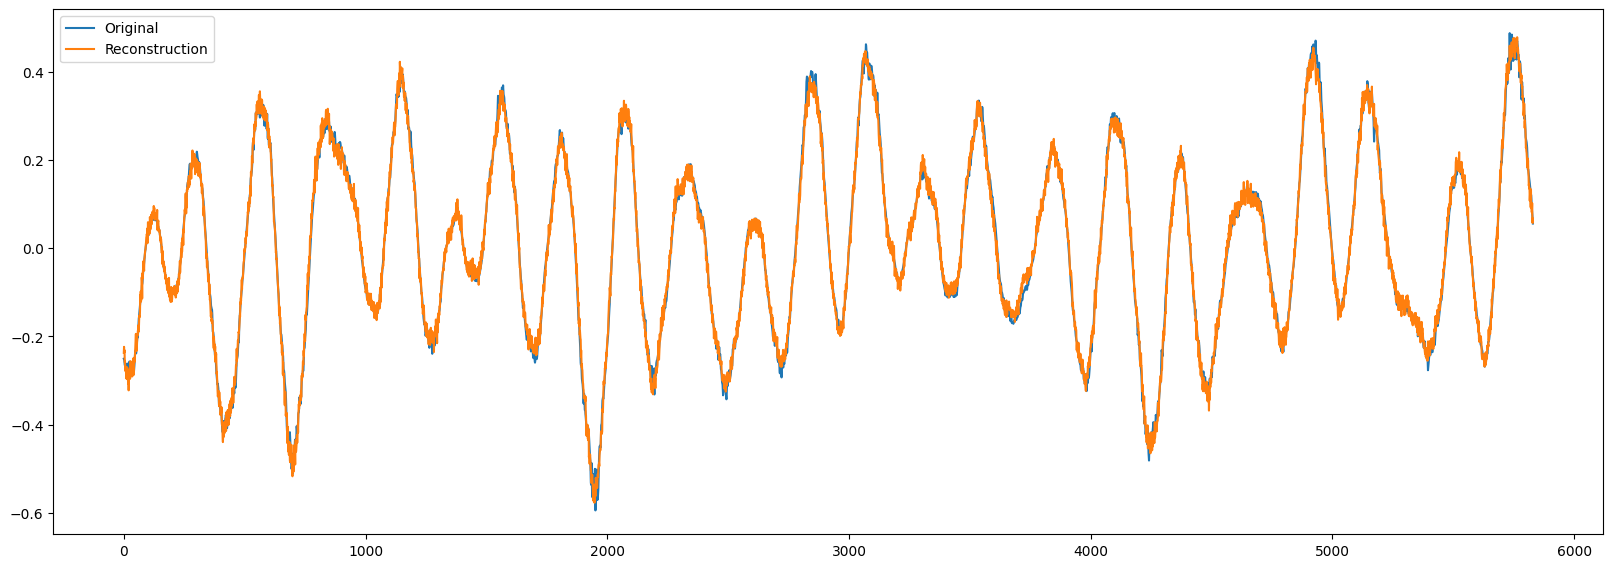

In [15]:
def plotagem_reconstrução(df_analisado):
    
    autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)
    n = 1
    x = np.arange(0, 5830)
    decoded_results = autoencoder.predict(df_analisado)
    plt.figure(figsize=(20, 15))

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.plot(x, df_analisado.iloc[i].values, label="Original")

        # Display reconstruction
        plt.plot(x, decoded_results[i], label="Reconstruction")

    plt.legend()
    plt.show()

plotagem_reconstrução(x_test_Cinco)

In [16]:
def data_split(data, p=0.1):
    if np.isscalar(p) and p >= 1.0:
        return data
    
    n_data = data.shape[0]
    idx = np.arange(n_data)
    np.random.shuffle(idx)
    
    idx = idx[:int(n_data * p)]
    return data.iloc[idx, :]

In [17]:
Teste_Caso = ["x_test_Baseline_splitted", "x_test_Cinco_splitted", "x_test_Dez_splitted", "x_test_Vinte_splitted"]
legenda = ['Baseline', 'DC1=5%', 'DC2=10%', 'DC3=20%'] 
cor = ['forestgreen', 'orange', 'royalblue', 'firebrick', 'magenta']

ntestes = 3 # Quantas variáveis de dano são adicionadas
n_it = 40 #Numero de conjuntos
n_vbatch = 5 #Numero de rodadas do AE - variabilidade do processador
n_passagens = 50  #Numero de passagens para cada ponto da curva ROC/cada conjunto
n_passag = '50'

n_pass_base = n_passagens/800
n_pass_dano = n_passagens/1000
    
Media = np.zeros((ntestes, n_it, n_vbatch))
Desvio = np.zeros((ntestes, n_it, n_vbatch))
Mediana = np.zeros((ntestes, n_it, n_vbatch))
DKL = np.zeros((ntestes, n_it, n_vbatch))
DI = np.zeros((ntestes, n_it, n_vbatch))

for n in range(n_vbatch):  
        
        autoencoder = run_autoencoder(dataBaseline, x_test_Baseline)

        reconstructions_train = autoencoder.predict(dataBaseline)
        train_loss = tf.keras.losses.mae(reconstructions_train, dataBaseline)

        #Ajuste de uma distribuição normal para Y=ln(train_loss)
        train_norm_log = np.log(train_loss)
        normFittolog_train = scipy.stats.norm.fit(train_norm_log)
        
        MediaTrain = normFittolog_train[0]
        DesvioTrain = normFittolog_train[1]

        min_val = tf.reduce_min(dataBaseline)
        max_val = tf.reduce_max(dataBaseline)

        for iter in range(n_it):
          print('Iteração: ', iter)
          for t in range(ntestes):

            x_test_Baseline_splitted = data_split(x_test_Baseline, p=n_pass_base)
            x_test_Cinco_splitted = data_split(x_test_Cinco, p=n_pass_dano)
            x_test_Dez_splitted = data_split(x_test_Dez, p=n_pass_dano)
            x_test_Vinte_splitted = data_split(x_test_Vinte, p=n_pass_dano)


            Teste = eval(Teste_Caso[t])
            Teste = Teste.values
            teste_data = (Teste - min_val) / (max_val - min_val)
            teste_data = tf.cast(teste_data, tf.float32)
          
            #Crie um gráfico semelhante, desta vez para o teste com dano
            reconstructions = autoencoder.predict(teste_data)
            test_loss = tf.keras.losses.mae(reconstructions, teste_data)
            
            test_norm_log = np.log(test_loss)
            normFittolog_test = scipy.stats.norm.fit(test_norm_log)
            
            
            #Media[t, iter, n] = MediaTestNC/fc   #Media do teste corrigido pelo fc
            Media[t, iter, n] = normFittolog_test[0]
            Desvio[t, iter, n] = normFittolog_test[1]
            Mediana[t, iter, n] = np.median(test_loss)
            
            DKL[t, iter, n] = np.log(Desvio[t, iter, n]/DesvioTrain)+((1/(2*(Desvio[t, iter, n]**2)))*((DesvioTrain**2)+(Media[t, iter, n]-MediaTrain)**2))-(1/2)      
            DI[t, iter, n] = np.log(DKL[t, iter, n]+math.exp(1))-1

32/32 [==============================] - 0s 2ms/step
Iteração:  0
1/1 [==============================] - 0s 10ms/step
Iteração:  1
1/1 [==============================] - 0s 9ms/step
Iteração:  2
1/1 [==============================] - 0s 10ms/step
Iteração:  3
1/1 [==============================] - 0s 10ms/step
Iteração:  4
1/1 [==============================] - 0s 10ms/step
Iteração:  5
1/1 [==============================] - 0s 10ms/step
Iteração:  6
1/1 [==============================] - 0s 9ms/step
Iteração:  7
1/1 [==============================] - 0s 10ms/step
Iteração:  8
1/1 [==============================] - 0s 10ms/step
Iteração:  9
1/1 [==============================] - 0s 10ms/step
Iteração:  10
1/1 [==============================] - 0s 10ms/step
Iteração:  11
1/1 [==============================] - 0s 10ms/step
Iteração:  12
1/1 [==============================] - 0s 10ms/step
Iteração:  13
1/1 [==============================] - 0s 10ms/step
Iteração:  14
1/1 [================

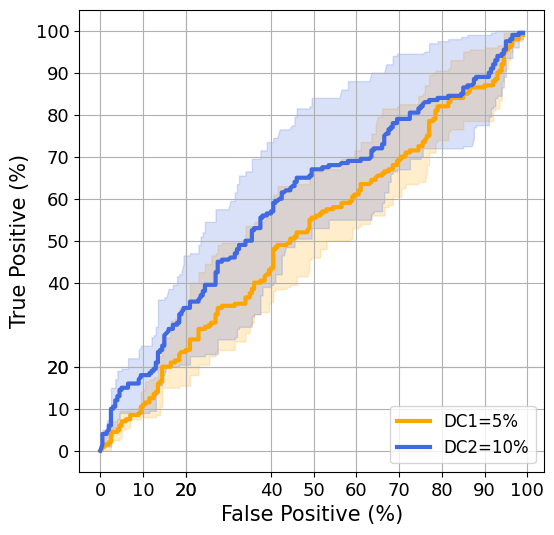

In [22]:
## ROC based KLD
# Calculate (P || q)
n_thresholds = 5000

metrica = DI  # Media, Desvio, Mediana ou DI
metric = 'DKL'

verdadeiros_negativos = np.zeros((2, n_thresholds, n_vbatch))  # 5%, 10%, and 20%
verdadeiros_positivos = np.zeros((2, n_thresholds, n_vbatch))
falsos_negativos = np.zeros((2, n_thresholds, n_vbatch))
falsos_positivos = np.zeros((2, n_thresholds, n_vbatch))

tpr = np.zeros((2, n_thresholds, n_vbatch))
fpr = np.zeros((2, n_thresholds, n_vbatch))

# Plots

for nvar in range(n_vbatch):
    sem_dano = metrica[0, :, nvar]

    min_threshold = metrica[:, :, nvar].min()
    max_threshold = metrica[:, :, nvar].max()

    for caso in range(metrica.shape[0] - 1):  # Cenarios de 5%, 10% e 20%
        com_dano = metrica[caso + 1, :, nvar]

        thresholds = np.linspace(min_threshold, max_threshold, n_thresholds)
        for idx, threshold in enumerate(thresholds):
            verdadeiros_negativos[caso, idx, nvar] = np.sum(sem_dano <= threshold)
            verdadeiros_positivos[caso, idx, nvar] = np.sum(com_dano > threshold)
            falsos_negativos[caso, idx, nvar] = np.sum(com_dano <= threshold)
            falsos_positivos[caso, idx, nvar] = np.sum(sem_dano > threshold)

            tpr[caso, idx, nvar] = verdadeiros_positivos[caso, idx, nvar] / (
            verdadeiros_positivos[caso, idx, nvar] + falsos_negativos[caso, idx, nvar])
            fpr[caso, idx, nvar] = falsos_positivos[caso, idx, nvar] / (
            falsos_positivos[caso, idx, nvar] + verdadeiros_negativos[caso, idx, nvar])

tprMean = np.zeros((2, n_thresholds))
fprMean = np.zeros((2, n_thresholds))

fig, ax2 = plt.subplots()

# Obtem a media e desvio das taxas de VPs e FPs para cada cenario e threshold
for caso in range(metrica.shape[0] - 1):
    for idx in range(n_thresholds):
        # tpr e fpr
        tprMean[caso, idx] = np.mean(tpr[caso, idx, :])
        fprMean[caso, idx] = np.mean(fpr[caso, idx, :])

    # Calcula os percentis 2.5 e 97.5 para criar a faixa de confiança
    percentile_2_5 = np.percentile(tpr[caso, :, :], 5, axis=1) * 100
    percentile_97_5 = np.percentile(tpr[caso, :, :], 95, axis=1) * 100

    ax2.plot(fprMean[caso, :] * 100, tprMean[caso, :] * 100, linewidth=3.0, color=cor[caso + 1],
             label=f'{legenda[caso + 1]}')
    ax2.fill_between(fprMean[caso, :] * 100, percentile_2_5, percentile_97_5, color=cor[caso + 1], alpha=0.2)

ax2.legend(loc='lower right', numpoints=1, fontsize=12)
plt.xlabel('False Positive (%)', fontsize=15)
plt.xticks([0, 10, 20, 20, 40, 50, 60, 70, 80, 90, 100], fontsize=13)
plt.yticks([0, 10, 20, 20, 40, 50, 60, 70, 80, 90, 100], fontsize=13)
plt.ylabel('True Positive (%)', fontsize=15)
plt.grid(True)
fig.set_size_inches(6, 6)


Iteração:  0
5/5 [==============================] - 0s 5ms/step
x_test_Baseline_splitted


TypeError: eval() arg 1 must be a string, bytes or code object

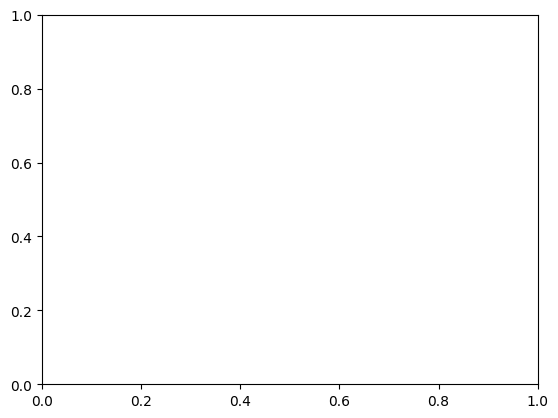

In [29]:
def plot_KLD(ncenarios):
    Teste_Caso = ["x_test_Baseline_splitted", "x_test_Cinco_splitted", "x_test_Dez_splitted", "x_test_Vinte_splitted"]

    n_teste = 0.8  #Treinado com 100 dados de aceleração do baseline (testado 80%)

    #Divide os dados baseline em dois conjuntos - para treinamento e validacao
    baseline_train, baseline_valid = train_test_split(
        dataBaseline_train, test_size=n_teste, random_state=21
    )

    linha = [(5, (10, 3)), 'solid', 'solid', 'solid', 'solid']

    n_it = 1 #Numero de amostras

    n_vbatch = 4 #Conjuntos de passagens de veículos analisados (50 a 400 de 50 em 50)

    n_pass_base = np.linspace((0.01/n_teste), (0.1/n_teste), num=n_vbatch)  #Numero de passagens de veículos (de 50 a 400 passagens dos dados de teste(validacao))
    n_pass_dano = np.linspace(0.01, 0.1, num=n_vbatch)  #Idem ''                ''             ''
    
    nPosVeh = 4
    
    for i in range(nPosVeh):
                        
        Teste = np.zeros((ncenarios, x_test_Baseline.shape[0], x_test_Baseline.shape[1], n_it, n_vbatch))
        Media = np.zeros((ncenarios, n_it, n_vbatch))
        Desvio = np.zeros((ncenarios, n_it, n_vbatch))
        
        MediaTrain = np.zeros((n_it))
        DesvioTrain = np.zeros((n_it))
        MedianaTrain = np.zeros((n_it))
        
        autoencoder = run_autoencoder(baseline_train, baseline_valid)

        min_val = tf.reduce_min(baseline_train)
        max_val = tf.reduce_max(baseline_train)
        
        for n in range(n_vbatch):  
            p_base = n_pass_base[n]
            p_dano = n_pass_dano[n]
                
            for iter in range(n_it):
              print('Iteração: ', iter)
                           
              reconstructions_train = autoencoder.predict(baseline_train)
              train_loss = tf.keras.losses.mae(reconstructions_train, baseline_train)

              #Ajuste de uma distribuição normal para Y=ln(train_loss)
              train_norm_log = np.log(train_loss)
              normFittolog_train = scipy.stats.norm.fit(train_norm_log)

              MediaTrain[iter] = normFittolog_train[0]
              DesvioTrain[iter] = normFittolog_train[1]
              
              for t in range(ncenarios):
                Teste_atual = Teste_Caso[t]
                print(Teste_atual)

                x_test_Baseline_splitted = data_split(x_test_Baseline, p=0.0125)
                x_test_Cinco_splitted = data_split(x_test_Cinco, p=0.01)
                x_test_Dez_splitted = data_split(x_test_Dez, p=0.01)
                x_test_Vinte_splitted = data_split(x_test_Vinte, p=0.01)

                Teste_atual = eval(Teste_Caso)


                Teste_atual = Teste_atual.values

                teste_data = (Teste - min_val) / (max_val - min_val)
                teste_data = tf.cast(teste_data, tf.float32)

                
                
                #Crie um gráfico semelhante, desta vez para o teste com dano
                reconstructions = autoencoder.predict(teste_data)
                test_loss = tf.keras.losses.mae(reconstructions, teste_data)
                
                #Ajusta a distribuição lognormal para os dados de teste
                test_norm_log = np.log(test_loss)
                normFittolog_test = scipy.stats.norm.fit(test_norm_log)
                
                
                #Media[t, iter, n] = MediaTestNC/fc   #Media do teste corrigido pelo fc
                Media[t, iter, n] = normFittolog_test[0]
                Desvio[t, iter, n] = normFittolog_test[1]
                              
                print('Media=')
                print(Media[0,0,0])
                
        
        n_vbatch = len(Media[0,0,:]) # Numero de conjunto de passagens analizadas
        ncenarios = len(Media[:,0,0]) #Numero de cenarios analisados
    
        #calculate (P || q)
        DI = np.zeros((ncenarios, n_vbatch))
        na = 0 #numero da amostra (só uma amostra de 400 dados)
    
        for nc in range (ncenarios):
            for nb in range (n_vbatch):
                
                DKL = np.log(Desvio[nc,na,nb]/DesvioTrain)+((1/(2*(Desvio[nc,na,nb]**2)))*((DesvioTrain**2)+(Media[nc,na,nb]-MediaTrain)**2))-(1/2)      
                DI[nc, nb] = np.log(DKL+math.exp(1))-1
    
        DamageIndex = DI
       
        xmin = n_pass_base[0]*x_test_Baseline.shape[0]
        xmax = n_pass_base[-1:]*x_test_Baseline.shape[0]
        x = np.linspace(xmin,xmax,n_vbatch)
    
        for i in range(ncenarios):
            ax.plot(x, DamageIndex[i,:], linestyle=linha[i], linewidth=1.8,  marker="o", markersize = 12, color=cor[i], markerfacecolor=cor[i])
    
        #ylabel_max = round_up(n=max(max(DamageIndex[-1:,:])))

    xticks = np.linspace(0, 100, 10, endpoint=True)
    yticks = np.linspace(0, 1.2, num=7, endpoint=True)
    #plt.legend(legenda, loc=(0.65, 0.65), numpoints =1, fontsize=25)
    plt.xlabel('Number of vehicle-crossing', fontsize=28)
    plt.xticks(xticks, fontsize=26)
    plt.yticks(yticks, fontsize=26)
    plt.ylabel('Damage index (KLD)', fontsize=28)
    fig.set_size_inches(10, 10)

    return Media, Desvio


fig, ax = plt.subplots()
Media, Desvio = plot_KLD(ncenarios=4)   
